# 美国纽约 citiBike 2018年骑行数据分析

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time,datetime

In [2]:
plt.style.use('lqj')

In [3]:
#将2018各月数据合并为全年数据
dataList=[]
for i in range(1,13):
    dataList.append(pd.read_csv(f'2018{i}.csv',usecols = ['tripduration','starttime','stoptime','start station id','end station id','bikeid','usertype','birth year','gender']))

Rawdata=pd.concat(dataList,ignore_index=True)
# 由于站点的经纬度和站点名称无用,故drop掉

In [3]:
len(Rawdata)
#总记录数17548339

17548339

In [4]:
Rawdata.shape
#2018全年共有17548339人次骑行

(17548339, 9)

#### 概览:
列分为:时间(起始时间点(str),骑行持续时间(int)),地点(起始地点id),车id(物,唯一标识),人(性别,出生年,用户类型)

In [3]:
#合并后的全年数据原始表
Rawdata.head()

,tripduration,starttime,stoptime,start station id,end station id,bikeid,usertype,birth year,gender
0,970,2018-01-01 13:50:57.4340,2018-01-01 14:07:08.1860,72.0,505.0,31956,Subscriber,1992,1
1,723,2018-01-01 15:33:30.1820,2018-01-01 15:45:33.3410,72.0,3255.0,32536,Subscriber,1969,1
2,496,2018-01-01 15:39:18.3370,2018-01-01 15:47:35.1720,72.0,525.0,16069,Subscriber,1956,1
3,306,2018-01-01 15:40:13.3720,2018-01-01 15:45:20.1910,72.0,447.0,31781,Subscriber,1974,1
4,306,2018-01-01 18:14:51.5680,2018-01-01 18:19:57.6420,72.0,3356.0,30319,Subscriber,1992,1


### 考虑增加的列
+ 线路区分:由于会出现2+4=1+5的情况,故不能使用起点id+终点id的方法确定一条线路,用str(startid)+str(stopid)来进行区分,同一条往返线路认定为2条不同的线路,因为方向不同,会导致调度的方向不同!
+ 年龄:计算出客户年龄(int类型,计算以2018年为基准)
+ 将年龄段划分bins=['少年[0-22]','青年[22-30]','壮年[30-40]','中年[40-55]','老年[55-200]'],200是因为原始数据中有错误的年龄数据
+ 小时时段H:(datetime类型)以每条记录的开始骑行的小时点H为准
+ 星期几的标志(将工作日与休息日分开)
+ 骑行持续时间:bins=[0,2,5,10,15,20,25,30,45,36000],注意:实际原始数据已将小于1分钟的数据剔除,根据cb1['tripduration'].describe()可知平均骑行时间,骑行时间>45分钟的人较少.

In [6]:
Rawdata['start station id']=Rawdata['start station id'].astype(str)
Rawdata['end station id']=Rawdata['end station id'].astype(str)
Rawdata['route']=Rawdata['start station id']+Rawdata['end station id']
#设置骑行往返路径(往与返不认定为同一条路)
Rawdata['birth year']=2018-Rawdata['birth year']

In [7]:
Rawdata.rename(columns={'birth year':'age'},inplace = True)
Rawdata.rename(columns={'start station id':'start_station_id','end station id':'end_station_id'},inplace = True)
#就地修改列名

In [8]:
Rawdata['starttime']=pd.to_datetime(Rawdata.starttime)
Rawdata['stoptime']=pd.to_datetime(Rawdata.stoptime)
Rawdata=Rawdata.set_index('starttime')
Rawdata['H']=Rawdata.index.hour
#添加所属小时段
#为方便进行时间序列处理,将str类型的starttime和stoptime转换为datetimeindex类型,而且还要留着用于resample

In [9]:
# 添加星期几的列,1代表周一 7代表周七 仍然以骑行出发时间为准
Rawdata['XingQi']=Rawdata.index.weekday+1

In [10]:
#将age装箱
age_bins=[0,22,30,40,55,200]
age_label=['少年[0-22]','青年[22-30]','壮年[30-40]','中年[40-55]','老年[55-200]']
Rawdata['age_group']=pd.cut(Rawdata.age,age_bins,labels=age_label)

In [11]:
tripLast_bins =[0,2*60,5*60,10*60,15*60,20*60,25*60,30*60,45*60,10*60*60]
group_tripduration = ['1-2m', '2-5m', '5-10m', '10-15m', '15-20m','20-25m','25-30m','30-45m','>45m']
Rawdata['tripLast_group'] = pd.cut(Rawdata['tripduration'], tripLast_bins, labels=group_tripduration)
#将划分好的数据装入桶中,并用group_tripduration的自定义名称作为数据对应进行标识

In [12]:
Rawdata.head(10)

,tripduration,stoptime,start_station_id,end_station_id,bikeid,usertype,age,gender,route,H,XingQi,age_group,tripLast_group
starttime,,,,,,,,,,,,,
2018-01-01 13:50:57.434,970,2018-01-01 14:07:08.186,72.0,505.0,31956,Subscriber,26,1,72.0505.0,13,1,青年[22-30],15-20m
2018-01-01 15:33:30.182,723,2018-01-01 15:45:33.341,72.0,3255.0,32536,Subscriber,49,1,72.03255.0,15,1,中年[40-55],10-15m
2018-01-01 15:39:18.337,496,2018-01-01 15:47:35.172,72.0,525.0,16069,Subscriber,62,1,72.0525.0,15,1,老年[55-200],5-10m
2018-01-01 15:40:13.372,306,2018-01-01 15:45:20.191,72.0,447.0,31781,Subscriber,44,1,72.0447.0,15,1,中年[40-55],5-10m
2018-01-01 18:14:51.568,306,2018-01-01 18:19:57.642,72.0,3356.0,30319,Subscriber,26,1,72.03356.0,18,1,青年[22-30],5-10m
2018-01-01 21:31:54.192,1602,2018-01-01 21:58:36.353,72.0,482.0,30106,Subscriber,50,1,72.0482.0,21,1,中年[40-55],25-30m
2018-01-02 07:54:53.646,722,2018-01-02 08:06:55.872,72.0,228.0,32059,Subscriber,40,1,72.0228.0,7,2,壮年[30-40],10-15m
2018-01-02 08:06:14.331,434,2018-01-02 08:13:28.767,72.0,173.0,30525,Subscriber,35,1,72.0173.0,8,2,壮年[30-40],5-10m
2018-01-02 08:10:15.255,366,2018-01-02 08:16:21.896,72.0,479.0,27439,Subscriber,44,1,72.0479.0,8,2,中年[40-55],5-10m


In [38]:
#得到route之后将id都删掉
Rdata=Rawdata.drop(columns=['start_station_id','end_station_id'])
Rdata.head()

,tripduration,stoptime,bikeid,usertype,age,gender,route,H,XingQi,age_group,tripLast_group
starttime,,,,,,,,,,,
2018-01-01 13:50:57.434,970,2018-01-01 14:07:08.186,31956,Subscriber,26,1,72.0505.0,13,1,青年[22-30],15-20m
2018-01-01 15:33:30.182,723,2018-01-01 15:45:33.341,32536,Subscriber,49,1,72.03255.0,15,1,中年[40-55],10-15m
2018-01-01 15:39:18.337,496,2018-01-01 15:47:35.172,16069,Subscriber,62,1,72.0525.0,15,1,老年[55-200],5-10m
2018-01-01 15:40:13.372,306,2018-01-01 15:45:20.191,31781,Subscriber,44,1,72.0447.0,15,1,中年[40-55],5-10m
2018-01-01 18:14:51.568,306,2018-01-01 18:19:57.642,30319,Subscriber,26,1,72.03356.0,18,1,青年[22-30],5-10m


## 概览

In [22]:
Rdata.info()
#gender:0--未知性别,1--男,2--女

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17548339 entries, 2018-01-01 13:50:57.434000 to 2018-12-31 23:59:51.085000
Data columns (total 11 columns):
tripduration      int64
stoptime          datetime64[ns]
bikeid            int64
usertype          object
age               int64
gender            int64
route             object
H                 int64
XingQi            int64
age_group         category
tripLast_group    category
dtypes: category(2), datetime64[ns](1), int64(6), object(2)
memory usage: 1.3+ GB


In [23]:
Rdata['tripduration'].describe()
#骑行时间概要:平均骑行时间16.46

count    1.754834e+07
mean     9.887432e+02
std      1.889584e+04
min      6.100000e+01
25%      3.580000e+02
50%      6.050000e+02
75%      1.060000e+03
max      1.951005e+07
Name: tripduration, dtype: float64

In [37]:
len(Rdata['start_station_id'].unique())
#共有站点819个

819

In [38]:
len(Rdata['bikeid'].unique())
#共有自行车15244辆

15244

In [39]:
Rdata['bikeid'].count()/15244
#每辆车一年平均出借1151次

1151.163670952506

In [40]:
#每辆自行车每日平均出借3.15次
1151.16/365

3.1538630136986305

In [41]:
#每次租借平均时长(分钟)
Rdata['tripduration'].sum()/Rdata['bikeid'].count()/60

16.479053295775362

# 人

In [42]:
#一年内出借给 普通客户与年度会员 的人次数
usertypes=Rdata['usertype'].value_counts()
usertypes

Subscriber    15614825
Customer       1933514
Name: usertype, dtype: int64

[Text(0, 0.5, '')]

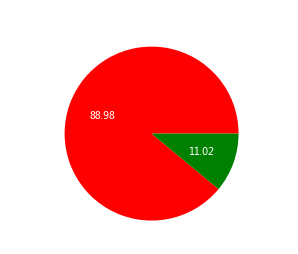

In [43]:
ax=usertypes.plot.pie(labels=['subscriber', 'customer'],autopct='%.2f',colors=['red','green'],title='年费会员为主')
ax.set(ylabel='')

In [44]:
#客户的性别比例
group_byGender=Rdata['gender'].value_counts()
group_byGender

1    11971322
2     4092462
0     1484555
Name: gender, dtype: int64

[Text(0, 0.5, '')]

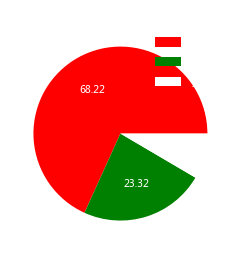

In [45]:
ax=group_byGender.plot.pie(labels=['男','女','未知'],autopct='%.2f',colors=['red','green','white'],title='男性客户为主')
ax.legend(['男','女','未知'])
ax.set(ylabel='')
#女性客户占比较少,是否因为bike自重太重?,如何提升女性客户参与度?

# 物 bikeID

In [15]:
#服务客户最多次数的十大 bikeID
Rdata.groupby('bikeid')['bikeid'].count().nlargest(10)
#效果一致:data.groupby('bikeid')['bikeid'].size().sort_values().tail(10)[::-1]

bikeid
30657    2862
32124    2728
32090    2707
32036    2692
32541    2681
32195    2627
32606    2593
30692    2584
31108    2576
30315    2570
Name: bikeid, dtype: int64

In [17]:
BikeServTop10=Rdata.groupby('bikeid').size().nlargest(10)
BikeServTop10

bikeid
30657    2862
32124    2728
32090    2707
32036    2692
32541    2681
32195    2627
32606    2593
30692    2584
31108    2576
30315    2570
dtype: int64

In [18]:
BikeServTop10.sum()
#服务最多的10辆车,总共有26620条骑行记录,而总骑行记录为17548339,占比非常小

26620

In [25]:
BikeServTop50=Rdata.groupby('bikeid').size().nlargest(50)
BikeServTop50.sum()/17548339
#服务最多的50辆车,占比仍然非常小

0.007246041918839157

# 金牌服务BIKE,id为30657的bike的流浪旅程:

In [47]:
# 可对某一个bikeid进行流浪旅程分析,暂未分析

In [132]:
Rdata.head()

,tripduration,stoptime,bikeid,usertype,age,gender,route,H,XingQi,age_group,tripLast_group
starttime,,,,,,,,,,,
2018-01-01 13:50:57.434,970,2018-01-01 14:07:08.186,31956,Subscriber,26,1,72.0505.0,13,1,青年[22-30],15-20m
2018-01-01 15:33:30.182,723,2018-01-01 15:45:33.341,32536,Subscriber,49,1,72.03255.0,15,1,中年[40-55],10-15m
2018-01-01 15:39:18.337,496,2018-01-01 15:47:35.172,16069,Subscriber,62,1,72.0525.0,15,1,老年[55-200],5-10m
2018-01-01 15:40:13.372,306,2018-01-01 15:45:20.191,31781,Subscriber,44,1,72.0447.0,15,1,中年[40-55],5-10m
2018-01-01 18:14:51.568,306,2018-01-01 18:19:57.642,30319,Subscriber,26,1,72.03356.0,18,1,青年[22-30],5-10m


# 骑行次数最多的十大线路:不算热门线路,因占骑行总次数的比例太低

In [27]:
Top10Route=Rdata.groupby('route').size().nlargest(10)
Top10Route
#骑行次数最多的十大线路骑行次数,占总体比例非常小,不能算最受欢迎的线路

route
2006.02006.0    7852
432.03263.0     7249
281.0281.0      6344
2006.03282.0    6215
460.03093.0     5456
3093.0460.0     5137
435.0509.0      4996
519.0492.0      4663
519.0498.0      4465
387.0387.0      4464
dtype: int64

In [28]:
Top10Route.sum()/17548339
#前十大骑行次数最多线路占比仍然非常小

0.003239109980722392

In [29]:
Top100Route=Rdata.groupby('route').size().nlargest(100)
Top100Route.sum()/17548339
#前100大骑行次数最多线路占比仍然非常小

0.01944964705776427

In [30]:
len(Rdata.groupby('route'))
#骑行路线共计347870条

347870

# 单独对排名第一的线路分析

In [41]:
#排名第一的线路:是一个循环2006--2006,位于纽约曼哈顿中央公园
# 7852/365=21.51,平均每天有21.5人骑行该线路
Rdata[Rdata.route=='2006.02006.0'].head()

,tripduration,starttime,stoptime,bikeid,usertype,age,gender,route,H,XingQi,age_group,tripLast_group
451219,1696,2018-01-01 15:50:59.600,2018-01-01 16:19:15.948,18236,Customer,49,0,2006.02006.0,15,1,中年[40-55],25-35m
451220,1690,2018-01-01 15:51:19.691,2018-01-01 16:19:30.117,32644,Customer,49,0,2006.02006.0,15,1,中年[40-55],25-35m
451232,496,2018-01-02 07:20:57.200,2018-01-02 07:29:13.876,16874,Customer,49,0,2006.02006.0,7,2,中年[40-55],5-10m
451233,1203,2018-01-02 08:05:08.143,2018-01-02 08:25:11.573,17867,Customer,49,0,2006.02006.0,8,2,中年[40-55],15-25m
451256,3487,2018-01-02 15:40:42.885,2018-01-02 16:38:50.800,28108,Customer,49,0,2006.02006.0,15,2,中年[40-55],>45m


In [134]:
#查看骑行次数排名第一路线的年龄分布
MostPopRoute=Rdata[['age_group']][Rdata.route=='2006.02006.0'].groupby('age_group').size()
MostPopRoute

age_group
少年[0-22]       434
青年[22-30]     1309
壮年[30-40]     1009
中年[40-55]     4810
老年[55-200]     290
dtype: int64

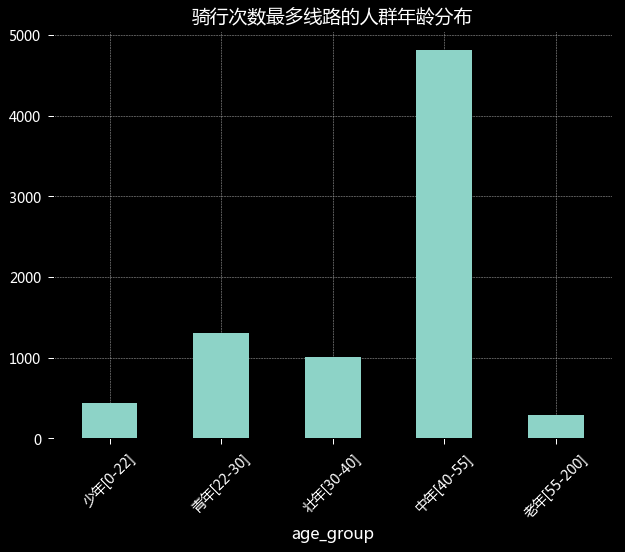

In [142]:
MostPopRoute.plot(kind='bar',title='骑行次数最多线路的人群年龄分布',rot=45)
#中年人占绝大部分

In [145]:
MostPopRoute=Rdata[['tripLast_group']][Rdata.route=='2006.02006.0'].groupby('tripLast_group').size()
MostPopRoute

tripLast_group
1-2m       335
2-5m       412
5-10m      348
10-15m     299
15-20m     411
20-25m     533
25-30m     693
30-45m    1593
>45m      3222
dtype: int64

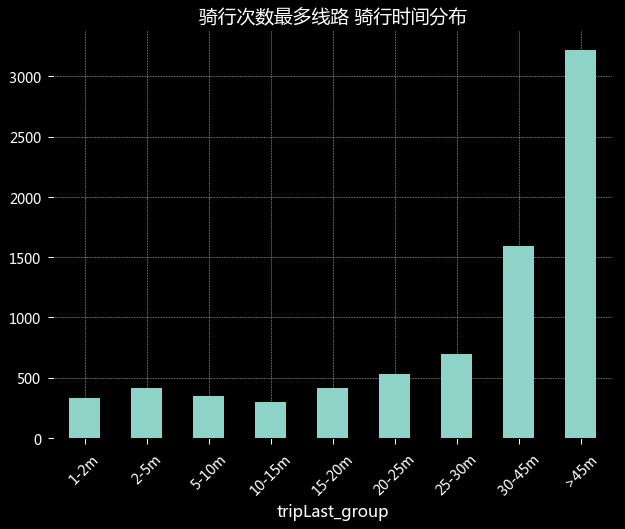

In [148]:
MostPopRoute.plot(kind='bar',title='骑行次数最多线路 骑行时间分布',rot=45)
#骑行时间绝大部分大于45分钟,该线路耗时较长

In [149]:
MostPopRoute=Rdata[['XingQi']][Rdata.route=='2006.02006.0'].groupby('XingQi').size()
MostPopRoute

XingQi
1     898
2     847
3     776
4     812
5    1089
6    1780
7    1650
dtype: int64

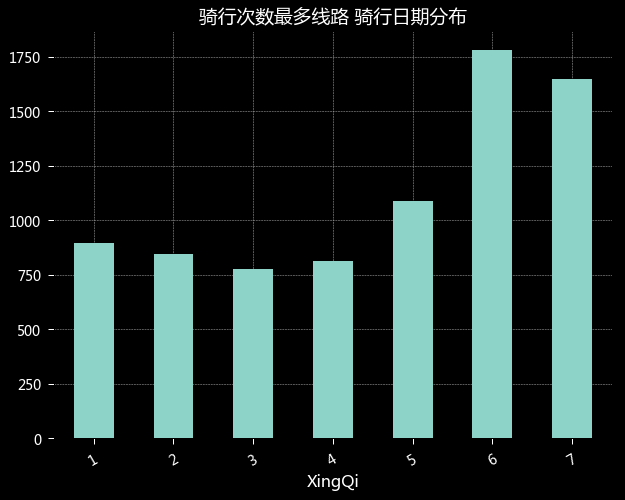

In [151]:
MostPopRoute.plot(kind='bar',title='骑行次数最多线路 骑行日期分布',rot=30)
#休息日骑行较多

In [152]:
MostPopRoute=Rdata[['H']][Rdata.route=='2006.02006.0'].groupby('H').size()
MostPopRoute

H
0      15
1      12
2       3
3       8
4       2
5      17
6      50
7     180
8     269
9     430
10    606
11    721
12    757
13    745
14    777
15    760
16    741
17    591
18    405
19    313
20    234
21    110
22     76
23     30
dtype: int64

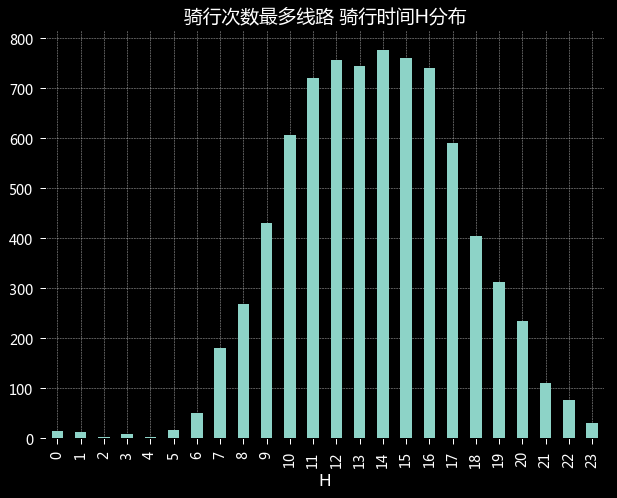

In [153]:
MostPopRoute.plot(kind='bar',title='骑行次数最多线路 骑行时间H分布')

In [154]:
MostPopRoute=Rdata[['gender']][Rdata.route=='2006.02006.0'].groupby('gender').size()
MostPopRoute

gender
0    3906
1    2346
2    1600
dtype: int64

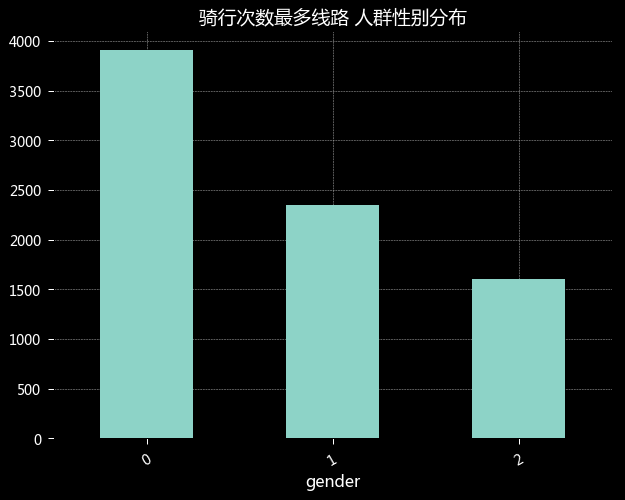

In [155]:
MostPopRoute.plot(kind='bar',title='骑行次数最多线路 人群性别分布',rot=30)
#未知性别骑行较多

In [156]:
MostPopRoute=Rdata[['usertype']][Rdata.route=='2006.02006.0'].groupby('usertype').size()
MostPopRoute
#普通客户远超本地客户

usertype
Customer      6433
Subscriber    1419
dtype: int64

In [158]:
data.groupby('usertype').size()
#原始数据中,年费客户也即本地客户远远多于游客

usertype
Customer       1933514
Subscriber    15614825
dtype: int64

# 此处显示该条线路的普通客户大大多于年费用户(也即本地用户)
# 较多游客在纽约曼哈顿中央公园打卡

# 每月骑行总次数及骑行总时间

In [42]:
#骑行次数按月计数
# group_byMonth=Rdata[['bikeid']].resample('M',how=len)
group_byMonth=Rdata[['bikeid']].resample('M').apply(len)
group_byMonth.head()

,bikeid
starttime,
2018-01-31,718994
2018-02-28,843114
2018-03-31,976672
2018-04-30,1307543
2018-05-31,1824710


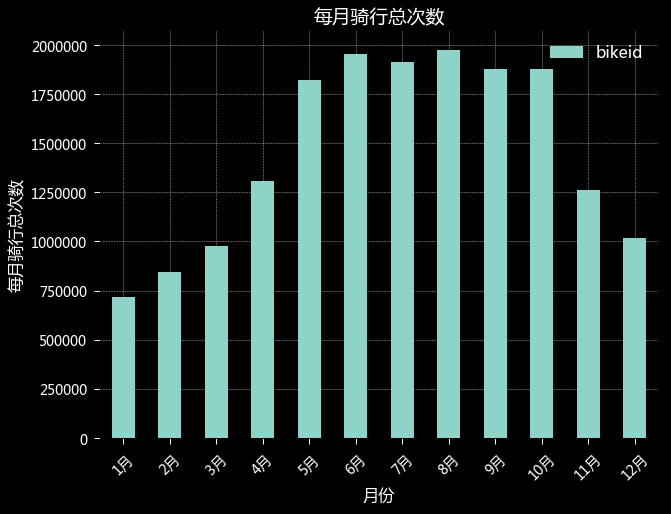

In [159]:
ax=group_byMonth.plot(kind='bar',title='每月骑行总次数')
ax.set(xlabel="月份", ylabel="每月骑行总次数")
ax.set_xticklabels(['1月','2月','3月','4月','5月','6月','7月','8月','9月','10月','11月','12月'],rotation=45);

#温暖的季节更适合骑行5-10月

In [45]:
#骑行总时长 按月计数,单位H(小时)
group_byMonth_Hours=(Rdata[['tripduration']].resample('M').apply('sum'))/(60*60)
group_byMonth_Hours.head()

,tripduration
starttime,
2018-01-31,165131.083333
2018-02-28,205485.100278
2018-03-31,239282.936389
2018-04-30,352639.742500
2018-05-31,568657.781111


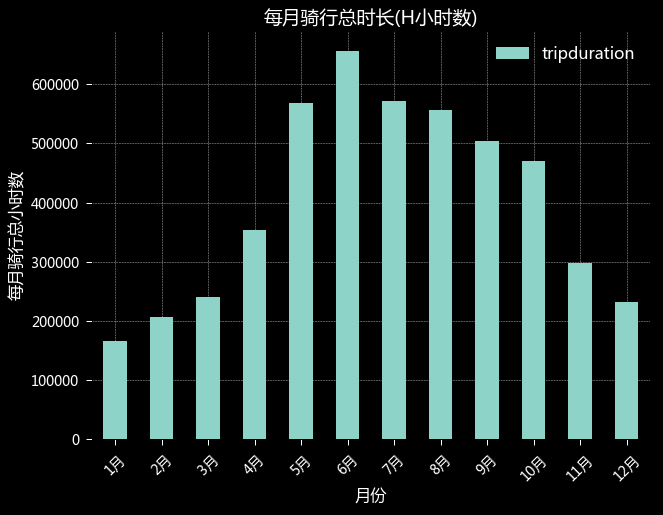

In [160]:
ax=group_byMonth_Hours.plot(kind='bar',title='每月骑行总时长(H小时数)')
ax.set(xlabel="月份", ylabel="每月骑行总小时数")
ax.set_xticklabels(['1月','2月','3月','4月','5月','6月','7月','8月','9月','10月','11月','12月'],rotation=45);

### 客户更偏好在5-10月骑行,天气温暖

# 每季度骑行总次数及总时间

In [49]:
#骑行次数按季度计数
group_byQ=Rdata[['bikeid']].resample('Q').apply(len)
group_byQ.head()

,bikeid
starttime,
2018-03-31,2538780
2018-06-30,5085356
2018-09-30,5768686
2018-12-31,4155517


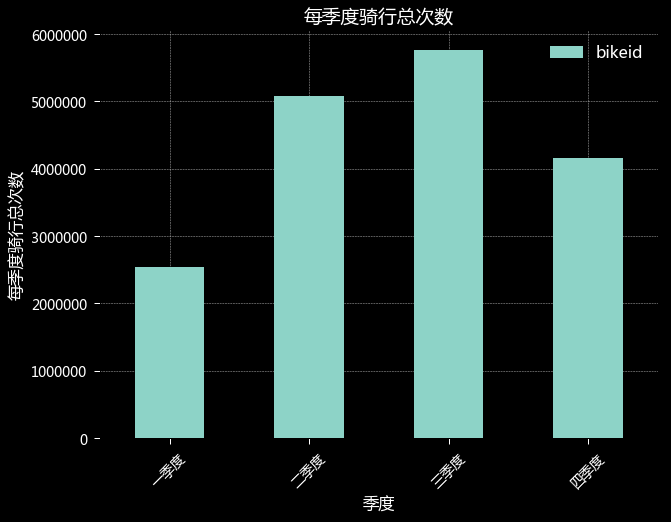

In [161]:
ax=group_byQ.plot(kind='bar',title='每季度骑行总次数')
ax.set(xlabel="季度", ylabel="每季度骑行总次数")
ax.set_xticklabels(['一季度','二季度','三季度','四季度'],rotation=45);

# 按骑行时长、年龄段、时间点  星期周末 分组统计

In [83]:
Rdata.head()

,tripduration,stoptime,bikeid,usertype,age,gender,route,H,XingQi,age_group,tripLast_group
starttime,,,,,,,,,,,
2018-01-01 13:50:57.434,970,2018-01-01 14:07:08.186,31956,Subscriber,26,1,72.0505.0,13,1,青年[22-30],15-20m
2018-01-01 15:33:30.182,723,2018-01-01 15:45:33.341,32536,Subscriber,49,1,72.03255.0,15,1,中年[40-55],10-15m
2018-01-01 15:39:18.337,496,2018-01-01 15:47:35.172,16069,Subscriber,62,1,72.0525.0,15,1,老年[55-200],5-10m
2018-01-01 15:40:13.372,306,2018-01-01 15:45:20.191,31781,Subscriber,44,1,72.0447.0,15,1,中年[40-55],5-10m
2018-01-01 18:14:51.568,306,2018-01-01 18:19:57.642,30319,Subscriber,26,1,72.03356.0,18,1,青年[22-30],5-10m


In [84]:
group_byTripLastBins=Rdata.groupby('tripLast_group').size()
group_byTripLastBins

tripLast_group
1-2m       318895
2-5m      2882743
5-10m     5508202
10-15m    3294787
15-20m    1968792
20-25m    1307666
25-30m     895600
30-45m    1039409
>45m       322704
dtype: int64

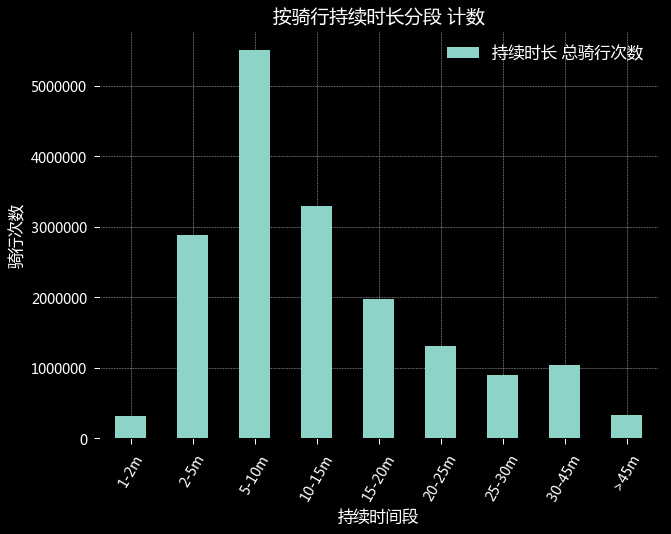

In [163]:
ax=group_byTripLastBins.plot(kind='bar',title='按骑行持续时长分段 计数')
ax.set(xlabel="持续时间段", ylabel="骑行次数")
ax.tick_params(axis='x', rotation=60)
ax.legend(['持续时长 总骑行次数'])
#可见绝大部分骑行时长在45分钟以内,另外,可以考虑鼓励多骑行时间的优惠政策切入时间点在哪里？

In [88]:
# 注意除了60后count,std是不准确的!
Rdata.tripduration.describe()/60
#结合骑行时间描述:平均骑行时间为16.48分钟,50%中位数:10分钟,75%的人骑行17.67分钟以内

count    292472.316667
mean         16.479053
std         314.930629
min           1.016667
25%           5.966667
50%          10.083333
75%          17.666667
max      325167.483333
Name: tripduration, dtype: float64

In [89]:
group_byAge=Rdata.groupby('age_group').size()
group_byAge

age_group
少年[0-22]       589849
青年[22-30]     4678035
壮年[30-40]     5035989
中年[40-55]     5560381
老年[55-200]    1684085
dtype: int64

In [91]:
group_byAge.sum()
#再次检验总数无误

17548339

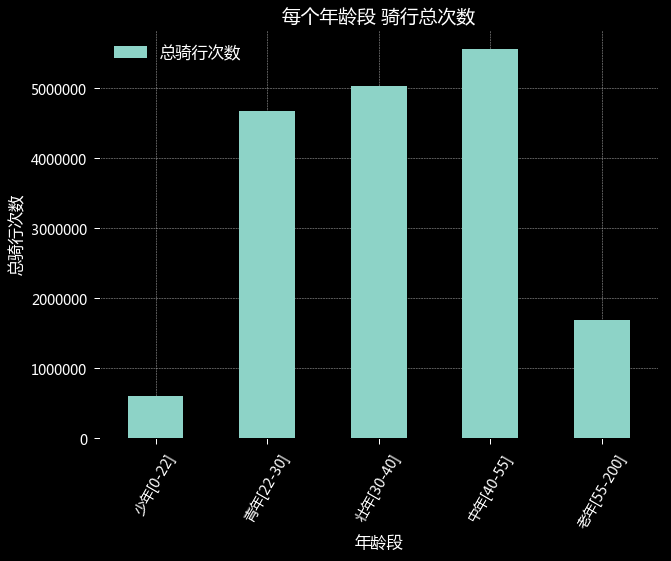

In [90]:
ax=group_byAge.plot(kind='bar',title='每个年龄段 骑行总次数')
ax.set(xlabel="年龄段", ylabel="总骑行次数")
ax.tick_params(axis='x', rotation=60)
ax.legend(['总骑行次数'])

In [61]:
# 每个年龄段骑行总时长(H按小时数计算)
group_byAge_TotalTime=(Rdata.groupby('age_group')['tripduration'].apply(sum))/(60*60)
group_byAge_TotalTime

age_group
少年[0-22]      1.783783e+05
青年[22-30]     1.246688e+06
壮年[30-40]     1.205150e+06
中年[40-55]     1.791463e+06
老年[55-200]    3.979878e+05
Name: tripduration, dtype: float64

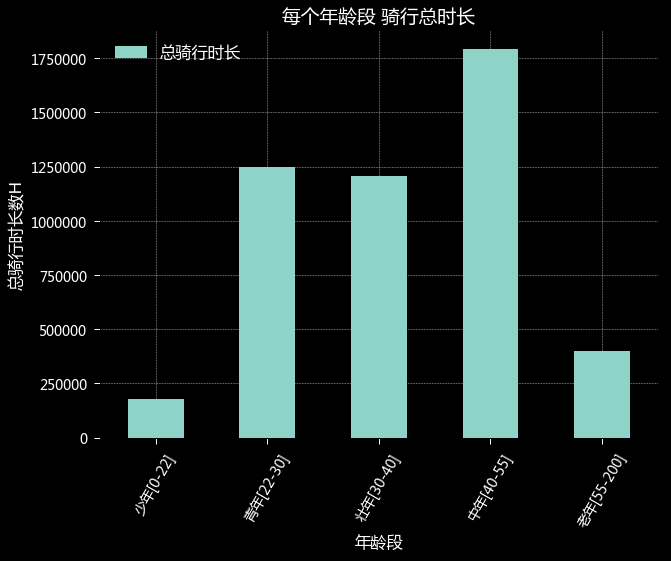

In [164]:
ax=group_byAge_TotalTime.plot(kind='bar',title='每个年龄段 骑行总时长')
ax.set(xlabel="年龄段", ylabel="总骑行时长数H")
ax.tick_params(axis='x', rotation=60)
ax.legend(['总骑行时长'])

In [77]:
# 每个年龄段骑行 平均时长(按分钟算)
group_byAge_MeanTime=(Rdata.groupby('age_group')['tripduration'].mean())/(60)
group_byAge_MeanTime

age_group
少年[0-22]      18.144815
青年[22-30]     15.989890
壮年[30-40]     14.358447
中年[40-55]     19.331013
老年[55-200]    14.179373
Name: tripduration, dtype: float64

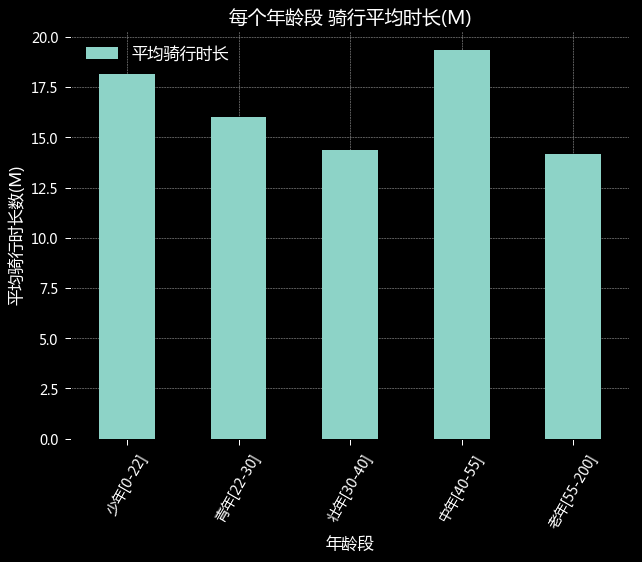

In [92]:
ax=group_byAge_MeanTime.plot(kind='bar',title='每个年龄段 骑行平均时长(M)')
ax.set(xlabel="年龄段", ylabel="平均骑行时长数(M)")
ax.tick_params(axis='x', rotation=60)
ax.legend(['平均骑行时长'])

In [102]:
Rdata.head()

,tripduration,stoptime,bikeid,usertype,age,gender,route,H,XingQi,age_group,tripLast_group
starttime,,,,,,,,,,,
2018-01-01 13:50:57.434,970,2018-01-01 14:07:08.186,31956,Subscriber,26,1,72.0505.0,13,1,青年[22-30],15-20m
2018-01-01 15:33:30.182,723,2018-01-01 15:45:33.341,32536,Subscriber,49,1,72.03255.0,15,1,中年[40-55],10-15m
2018-01-01 15:39:18.337,496,2018-01-01 15:47:35.172,16069,Subscriber,62,1,72.0525.0,15,1,老年[55-200],5-10m
2018-01-01 15:40:13.372,306,2018-01-01 15:45:20.191,31781,Subscriber,44,1,72.0447.0,15,1,中年[40-55],5-10m
2018-01-01 18:14:51.568,306,2018-01-01 18:19:57.642,30319,Subscriber,26,1,72.03356.0,18,1,青年[22-30],5-10m


In [105]:
group_byAgeAndGender=Rdata.pivot_table('bikeid',index=['age_group','gender'],aggfunc=len).unstack(level=1)
group_byAgeAndGender

bikeid                  
gender            0        1        2
age_group                            
少年[0-22]       4888   425597   159364
青年[22-30]     28904  3307877  1341254
壮年[30-40]     38198  3767853  1229938
中年[40-55]   1403234  3189442   967705
老年[55-200]     9331  1280553   394201

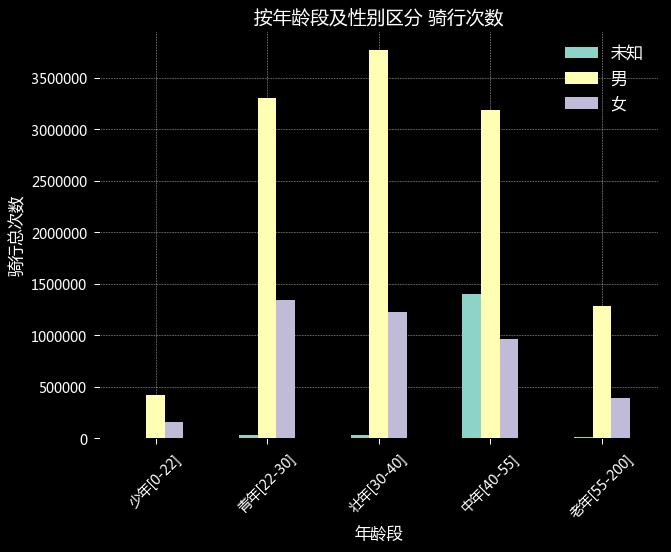

In [106]:
ax=group_byAgeAndGender.plot(kind='bar',title='按年龄段及性别区分 骑行次数')
ax.set(xlabel="年龄段", ylabel="骑行总次数")
ax.tick_params(axis='x', rotation=45)
ax.legend(['未知','男','女'])

In [94]:
Rdata.head()

,tripduration,stoptime,bikeid,usertype,age,gender,route,H,XingQi,age_group,tripLast_group
starttime,,,,,,,,,,,
2018-01-01 13:50:57.434,970,2018-01-01 14:07:08.186,31956,Subscriber,26,1,72.0505.0,13,1,青年[22-30],15-20m
2018-01-01 15:33:30.182,723,2018-01-01 15:45:33.341,32536,Subscriber,49,1,72.03255.0,15,1,中年[40-55],10-15m
2018-01-01 15:39:18.337,496,2018-01-01 15:47:35.172,16069,Subscriber,62,1,72.0525.0,15,1,老年[55-200],5-10m
2018-01-01 15:40:13.372,306,2018-01-01 15:45:20.191,31781,Subscriber,44,1,72.0447.0,15,1,中年[40-55],5-10m
2018-01-01 18:14:51.568,306,2018-01-01 18:19:57.642,30319,Subscriber,26,1,72.03356.0,18,1,青年[22-30],5-10m


# 按星期几分组分析

In [95]:
group_byXQ=Rdata.groupby('XingQi').size()
group_byXQ

XingQi
1    2535365
2    2699319
3    2737696
4    2738252
5    2602411
6    2250256
7    1985040
dtype: int64

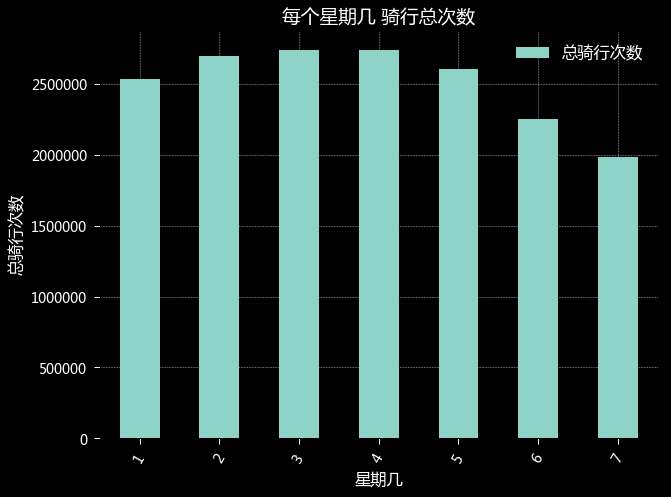

In [96]:
ax=group_byXQ.plot(kind='bar',title='每个星期几 骑行总次数')
ax.set(xlabel="星期几", ylabel="总骑行次数")
ax.tick_params(axis='x', rotation=60)
ax.legend(['总骑行次数'])

In [97]:
group_byXQ=(Rdata.groupby('XingQi')['tripduration'].sum())/(60*60)
group_byXQ

XingQi
1    668587.068889
2    678766.349444
3    703539.823056
4    697568.995278
5    694135.988333
6    750033.856667
7    627034.812222
Name: tripduration, dtype: float64

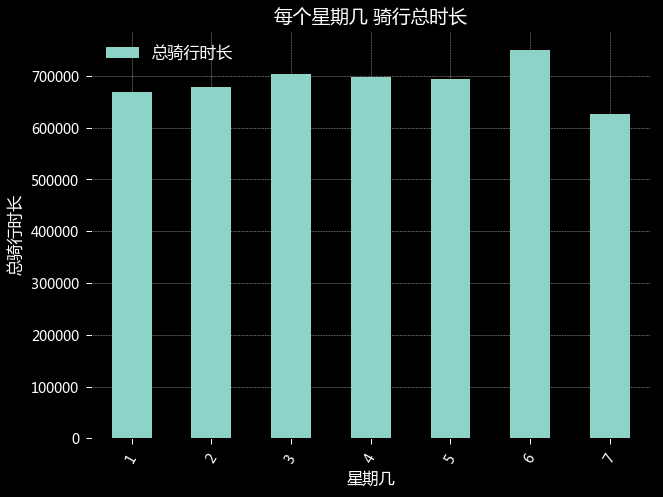

In [98]:
ax=group_byXQ.plot(kind='bar',title='每个星期几 骑行总时长')
ax.set(xlabel="星期几", ylabel="总骑行时长")
ax.tick_params(axis='x', rotation=60)
ax.legend(['总骑行时长'])

# 骑行期数 每天按时点分布 以出发的小时点数为准(H)

In [108]:
group_byStartTime=Rdata.groupby('H').size()
group_byStartTime

H
0      153529
1       85853
2       50145
3       31128
4       32763
5      113229
6      382833
7      807766
8     1412674
9     1111877
10     786065
11     826532
12     956564
13    1000809
14    1019691
15    1073021
16    1252798
17    1707105
18    1626014
19    1131276
20     770210
21     543730
22     404767
23     267960
dtype: int64

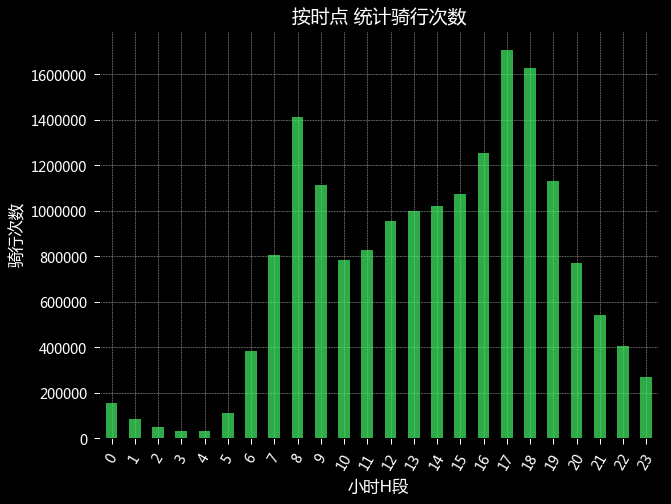

In [165]:
#一天24个小时,从0-23点,统计每个小时内的骑行次数,注意:
# 00:00:00-00:59:59,算作0
# 07:00:00-07:59:59算作7
ax=group_byStartTime.plot(title='按时点 统计骑行次数',kind='bar',color=['#42f468'],alpha=0.7)
ax.set(xlabel="小时H段", ylabel="骑行次数")
ax.tick_params(axis='x', rotation=60)

#可见存在双高峰,且下班高峰期使用次数要高于早高峰期

# 考虑到工作日及休息日的差异:
# 对照工作日和休息日骑行趋势:

In [39]:
groupby_XingQi_hour=(Rdata.groupby(['XingQi','H'])).size()
workday=groupby_XingQi_hour.loc[[1,2,3,4,5]]
groupby_workday=workday.unstack(level=0).mean(axis=1)

weekday=groupby_XingQi_hour.loc[[6,7]]
groupby_weekday=weekday.unstack(level=0).mean(axis=1)

week_compare_work=pd.DataFrame({'weekday':groupby_weekday,'workday':groupby_workday})

In [42]:
groupby_XingQi_hour.sum()
#检验记录总数正确

17548339

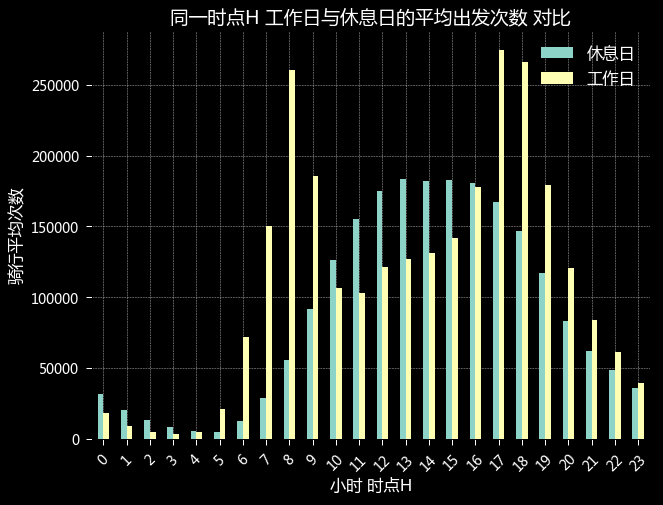

In [116]:
ax=week_compare_work.plot(kind='bar',title='同一时点H 工作日与休息日的平均出发次数 对比')
ax.set(xlabel="小时 时点H", ylabel="骑行平均次数")
ax.tick_params(axis='x', rotation=45)
ax.legend(['休息日','工作日'])

# 将工作日和休息日分别统计后可见,工作日呈双高峰期模式,而休息日为单高峰;
# !!!工作日晚高峰的使用量要大于早高峰!!!
# 休息日呈较标准的正态分布;

# 在两个时段,休息日相比工作日出发更多的时间点在:
### 1、在凌晨0-3点可能是休息日外出聚会晚归人群所致,
### 2、10点-16点都比工作日使用量要大，开启休息模式

# 工作日和休息日 每个时点的 平均骑行时长

In [117]:
# 考虑到工作日及休息日的差异:
mean_groupby_XingQi_hour=(Rdata.groupby(['XingQi','H']))['tripduration'].mean()
workday=mean_groupby_XingQi_hour.loc[[1,2,3,4,5]]
groupby_workday=workday.unstack(level=0).mean(axis=1)

weekday=mean_groupby_XingQi_hour.loc[[6,7]]
groupby_weekday=weekday.unstack(level=0).mean(axis=1)

week_compare_work=pd.DataFrame({'weekday':groupby_weekday,'workday':groupby_workday})

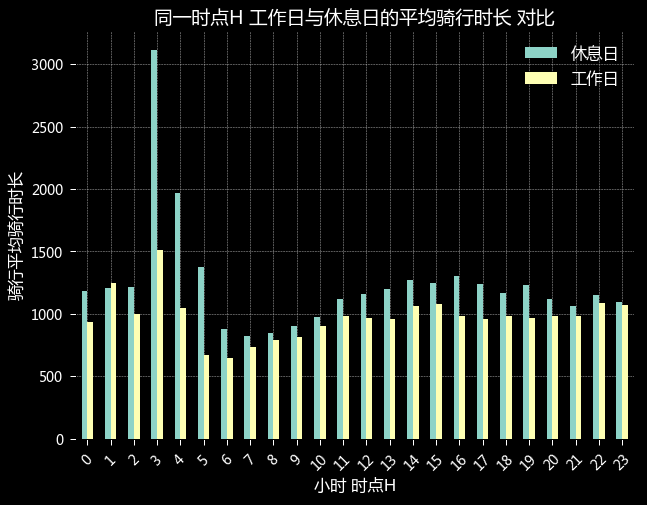

In [118]:
ax=week_compare_work.plot(kind='bar',title='同一时点H 工作日与休息日的平均骑行时长(S) 对比')
ax.set(xlabel="小时 时点H", ylabel="平均骑行时长(S)")
ax.tick_params(axis='x', rotation=45)
ax.legend(['休息日','工作日'])

#在3-4点出现了异常:异常突出

In [44]:
#对3-4点人群分布 的分析
groupby_age_weekday3_4=Rawdata[Rawdata.XingQi.isin([6,7]) & Rawdata.H.isin([3,4])].groupby(['age_group']).size()
groupby_age_weekday3_4

age_group
少年[0-22]      1868
青年[22-30]     9952
壮年[30-40]     6969
中年[40-55]     6483
老年[55-200]    1311
dtype: int64

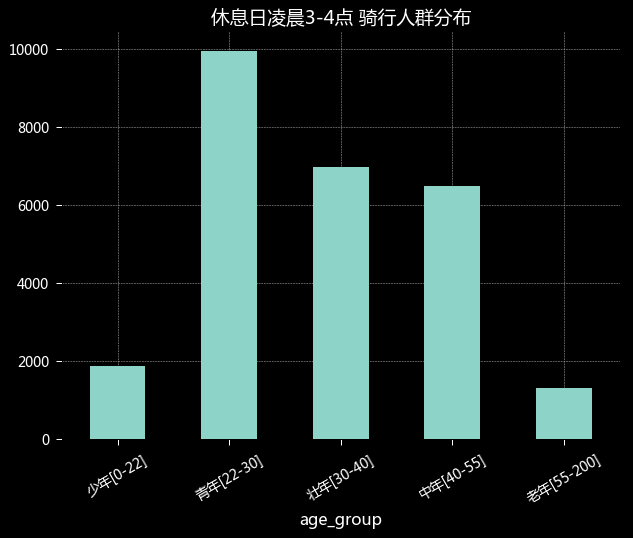

In [46]:
groupby_age_weekday3_4.plot(kind='bar',title='休息日凌晨3-4点 骑行人群分布',rot=30)

# 休息日3-4点还在外的青年人[22-30]较多

## 可见休息日的几乎每个时点,平均骑行时长都要比工作日长
#### 休息日更放松,悠闲

# 查看 工作日 早高峰和晚高峰期 出发的前十大站点

In [26]:
#   !  注意    !  此处使用的是Rawdata
Rawdata.head()

,tripduration,stoptime,start_station_id,end_station_id,bikeid,usertype,age,gender,route,H,XingQi,age_group,tripLast_group
starttime,,,,,,,,,,,,,
2018-01-01 13:50:57.434,970,2018-01-01 14:07:08.186,72.0,505.0,31956,Subscriber,26,1,72.0505.0,13,1,青年[22-30],15-20m
2018-01-01 15:33:30.182,723,2018-01-01 15:45:33.341,72.0,3255.0,32536,Subscriber,49,1,72.03255.0,15,1,中年[40-55],10-15m
2018-01-01 15:39:18.337,496,2018-01-01 15:47:35.172,72.0,525.0,16069,Subscriber,62,1,72.0525.0,15,1,老年[55-200],5-10m
2018-01-01 15:40:13.372,306,2018-01-01 15:45:20.191,72.0,447.0,31781,Subscriber,44,1,72.0447.0,15,1,中年[40-55],5-10m
2018-01-01 18:14:51.568,306,2018-01-01 18:19:57.642,72.0,3356.0,30319,Subscriber,26,1,72.03356.0,18,1,青年[22-30],5-10m


In [22]:
TenBusiestStation7_9=Rawdata[Rawdata.XingQi.isin([1,2,3,4,5])].groupby(['H','start_station_id']).size().loc[[7,8,9]].nlargest(10)
TenBusiestStation7_9

# 工作日早高峰7-9点,开始骑行次数最多的站点

H  start_station_id
8  519.0               15257
9  519.0               11800
8  445.0               10031
   514.0                9997
7  519.0                9074
   3255.0               8698
8  3164.0               8272
   517.0                8254
   545.0                7552
   465.0                7533
dtype: int64

In [20]:
# 早高峰开始骑行 十大站点
# 519 445 514 3255 3164 517 545 465 

In [31]:
groupby_age_workday_7_9=Rawdata[Rawdata.XingQi.isin([1,2,3,4,5]) & Rawdata.H.isin([7,8,9])].groupby(['age_group']).size()
groupby_age_workday_7_9

age_group
少年[0-22]       61259
青年[22-30]     796467
壮年[30-40]     925313
中年[40-55]     896799
老年[55-200]    301086
dtype: int64

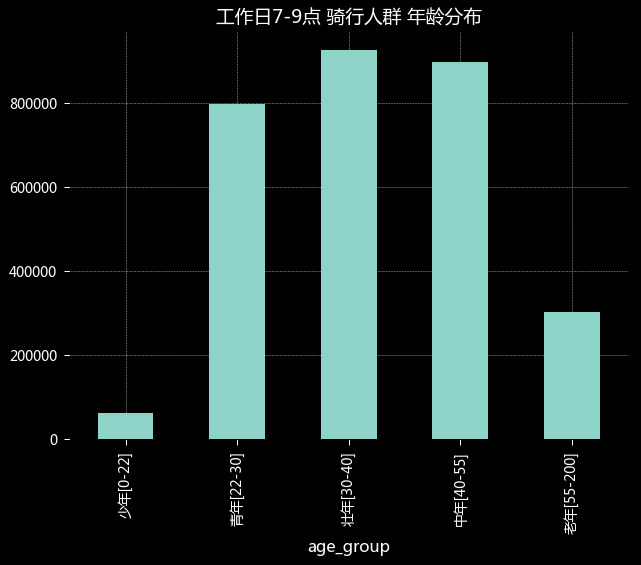

In [32]:
groupby_age_workday_7_9.plot(kind='bar',title='工作日7-9点 骑行人群 年龄分布')

In [23]:
TenBusiestStation17_19=Rawdata[Rawdata.XingQi.isin([1,2,3,4,5])].groupby(['H','end_station_id']).size().loc[[17,18,19]].nlargest(10)
TenBusiestStation17_19

H   end_station_id
17  519.0             23753
18  519.0             15181
17  3255.0            14714
    514.0             12100
    490.0             10522
    379.0              9568
    477.0              9407
19  445.0              9224
17  492.0              9174
    498.0              8753
dtype: int64

In [ ]:
# 晚高峰开始骑行 十大站点 
# 519 3255 514 490 379 477 445 492 498

In [33]:
groupby_age_workday17_19=Rawdata[Rawdata.XingQi.isin([1,2,3,4,5]) & Rawdata.H.isin([17,18,19])].groupby(['age_group']).size()
groupby_age_workday17_19

age_group
少年[0-22]       103959
青年[22-30]     1036631
壮年[30-40]     1114001
中年[40-55]     1036076
老年[55-200]     311857
dtype: int64

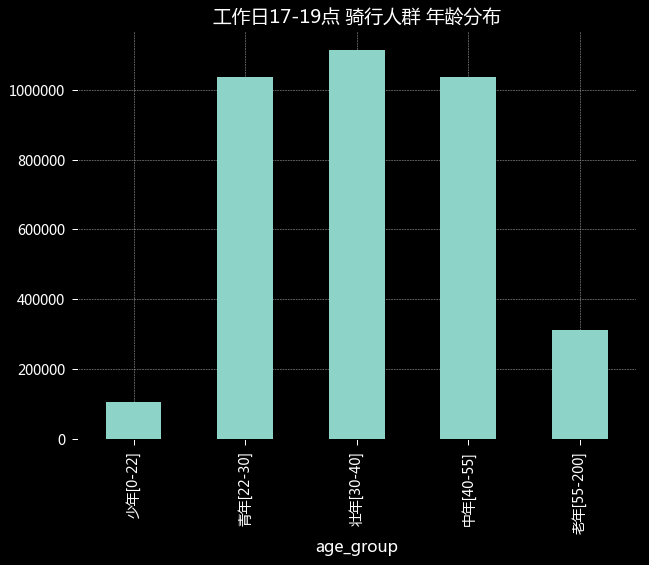

In [34]:
groupby_age_workday17_19.plot(kind='bar',title='工作日17-19点 骑行人群 年龄分布')

In [24]:
TenBusiestStation12_16=Rawdata[Rawdata.XingQi.isin([6,7])].groupby(['H','start_station_id']).size().loc[[12,13,14,15,16]].nlargest(10)
TenBusiestStation12_16

#休息日 中午高峰12-16点,开始骑行次数最多的站点

H   start_station_id
16  2006.0              2621
14  2006.0              2618
15  2006.0              2615
14  497.0               2586
    281.0               2584
15  497.0               2563
13  2006.0              2559
16  514.0               2522
    426.0               2518
13  497.0               2514
dtype: int64

In [35]:
groupby_age_weekday12_16=Rawdata[Rawdata.XingQi.isin([6,7]) & Rawdata.H.isin([12,13,14,15,16])].groupby(['age_group']).size()
groupby_age_weekday12_16

age_group
少年[0-22]       59608
青年[22-30]     507097
壮年[30-40]     471930
中年[40-55]     622460
老年[55-200]    147434
dtype: int64

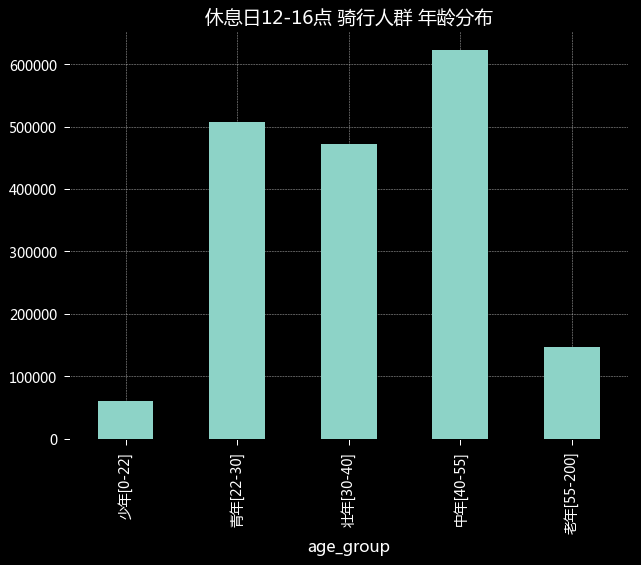

In [36]:
groupby_age_weekday12_16.plot(kind='bar',title='休息日12-16点 骑行人群 年龄分布')

In [ ]:
# 休息日愿意出门骑车出行人数减半!